# Determining the price of automobiles

The service for the sale of used cars is developing an application to attract new customers. Itis supposed that In it, user can quickly find out the market value of your car. Historical data is available: technical specifications, complete sets and prices of cars.

### The purpose of the study

- <b>Build a model to determine the cost</b>

Important to the customer:

- prediction quality;
- prediction speed;
- training time.

### Data Description

<b>Signs</b>
- DateCrawled — date of downloading the questionnaire from the database
- VehicleType — type of car body
- RegistrationYear — the year of registration of the car
- Gearbox — type of gearbox
- Power — power (hp)
- Model — car model
- Kilometer — mileage (km)
- RegistrationMonth — month of car registration
- FuelType — fuel type
- Brand — car brand
- NotRepaired — was the car under repair or not
- DateCreated — date of creation of the questionnaire
- NumberOfPictures — number of photos of the car
- PostalCode — postal code of the questionnaire owner (user)
- lastSeen — the date of the user's last activity

<b>Target attribute</b>
- Price — price (Euro)

### Research plan

1) Data preparation

2) Training of different models

3) Analysis of the speed and quality of models

## Data preparation

In [60]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import time 

from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

RND = 12345

import warnings
warnings.filterwarnings('ignore')

In [61]:
try:
    df = pd.read_csv('/Users/vladislav/Documents/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [62]:
new_columns = df.columns.str.lower()
df.set_axis(new_columns, axis = 'columns', inplace = True)

Uploaded the data and changed the column names to lowercase for convenience

In [63]:
def first_check(dataset):
    print(dataset.info())
    display(dataset.head())
    display(dataset.tail())
    display(df.describe())
    display(df.describe(include=['object', 'bool']))
    print('Duplicates: ', dataset.duplicated().sum())

In [64]:
first_check(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,datecrawled,vehicletype,gearbox,model,fueltype,brand,notrepaired,datecreated,lastseen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


Duplicates:  4


**Primary analysis:**
- 354365 rows and 16 columns
- There are missing values
- The average cost of a car is 2700 euros
- The minimum year of registration of the car is 1000, the maximum is 9999. I propose to designate the range in years selected from the percentiles
- Max.value in the power of the car in horsepower = 20,000. The indicator is very fantastic. Let's choose a range from percentiles
- The minimum mileage of a car is 5000, the maximum is 150,000, but at the same time many cars have a maximum mileage. It is possible to simply restrict data entry on the site
- The months are incorrectly set. If the first month is 0, then the last month should not be 12
- Column with photos of cars. We don't have them

**-------------**

- 8 unique types of car body
- Cars with manual transmission are more common
- Gasoline-powered cars are more common
- The most popular Volkswagen car brand
- There are a lot of omissions in the column about car repairs, but cars without repairs are more common

There are uninformative signs in the dataset. I suggest not to waste time on them and work in the future only with the necessary signs.

### Analysis and processing

**Categorical features**

<AxesSubplot:>

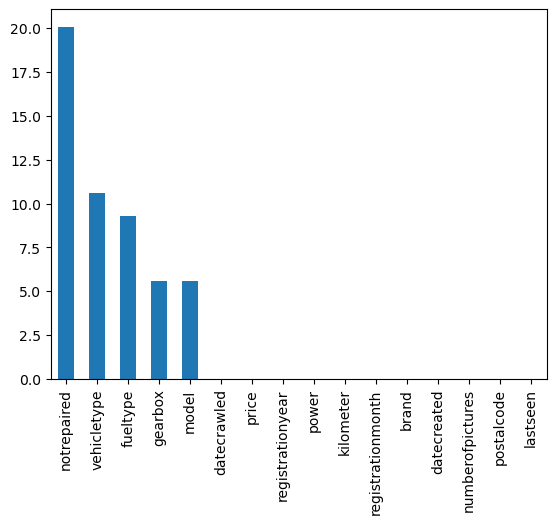

In [65]:
(df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100).plot(kind='bar')

**The amount of missing values is: **
- 20% in the NotRepaired column. Most likely, the owners missed this because the car had not been repaired before. Or they simply hid the information so that the car would not seem less attractive to buy
- 10% in the Vehicle Type column
- 9% in the FuelType column
- 5% in the GearBox column
- 5% in the Model column

The remaining columns have missing values, possibly due to problems with data unloading, since only car owners can answer these questions. Fill in missing values with mods by grouping by other attributes of objects.

In [66]:
df['notrepaired'] = df['notrepaired'].fillna('no')

In [67]:
def fill_with_mode(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(
        lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [68]:
fill_with_mode('model', 'brand', 'registrationyear')
fill_with_mode('fueltype', 'brand', 'model')
fill_with_mode('vehicletype', 'brand', 'model')
fill_with_mode('gearbox', 'brand', 'model')

In [69]:
filled_columns = ['model', 'gearbox', 'brand', 'vehicletype', 'fueltype']
def count_empty_category(column):
    print(column, ' : ' ,df[column][df[column] == 'Empty'].count())

In [70]:
for column in filled_columns:
    count_empty_category(column)

model  :  3442
gearbox  :  21
brand  :  0
vehicletype  :  25
fueltype  :  14


3442 objects for sale with unknown car models. I suggest renaming them to Other. Other indicators are small.

In [71]:
df['model'] = df['model'].replace('Empty', 'other')

In [72]:
def make_plotbar(index, title):
    pivot = pd.DataFrame(df.pivot_table(index=index, aggfunc="size").sort_values(ascending=False)).head(10)
    pivot.columns = ['count']
    plt.figure(figsize=(12,6))
    plt.title(title)
    sns.barplot(x='count', y=pivot.index, data=pivot)

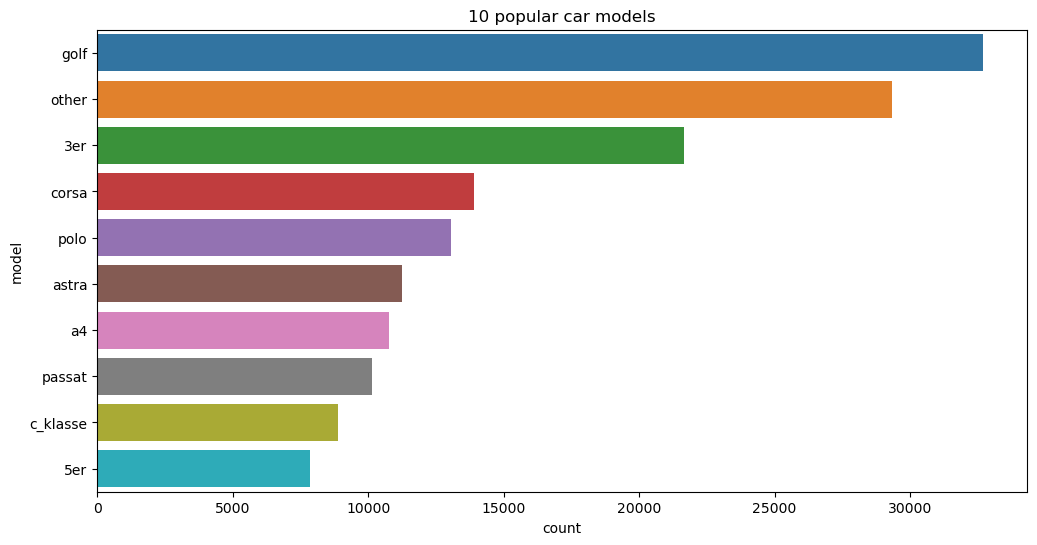

In [73]:
make_plotbar('model', '10 popular car models')

The most popular car model is golf

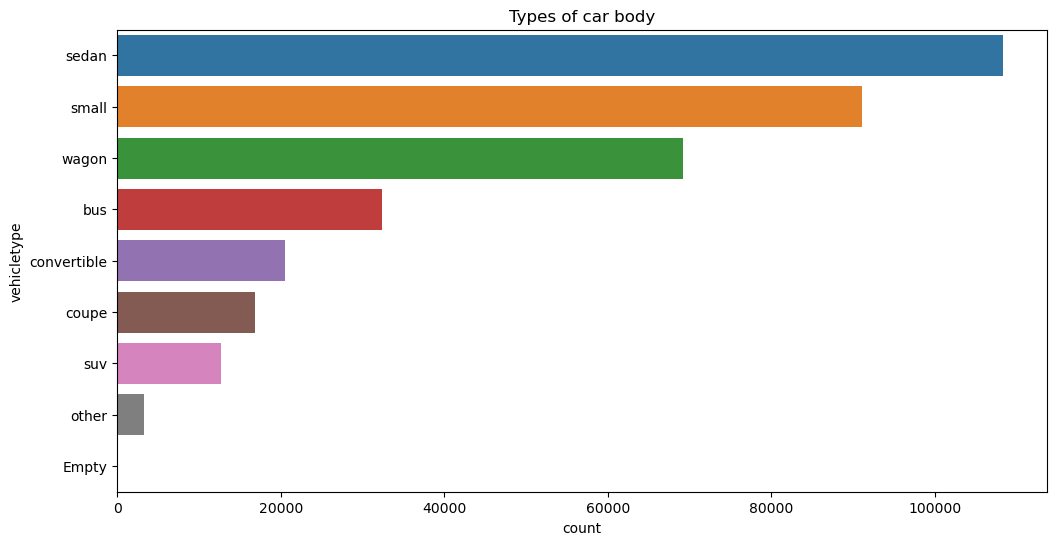

In [74]:
make_plotbar('vehicletype', 'Types of car body')

Самый популярный тип автомобильного кузова - седан

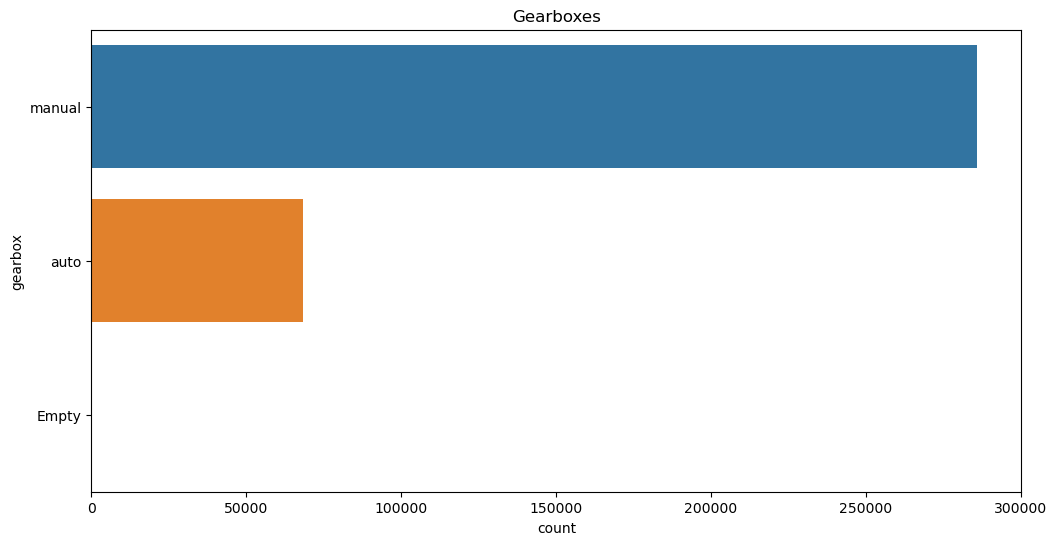

In [75]:
make_plotbar('gearbox', 'Gearboxes')

Cars with manual transmission exceed the number of cars with automatic transmission

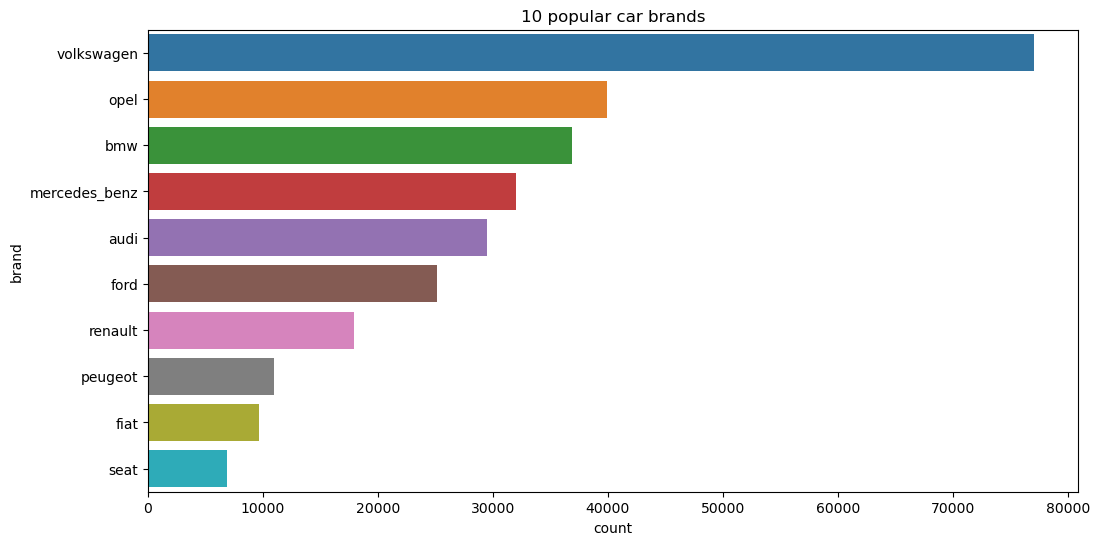

In [76]:
make_plotbar('brand', '10 popular car brands')

Volkswagen is the best-selling car

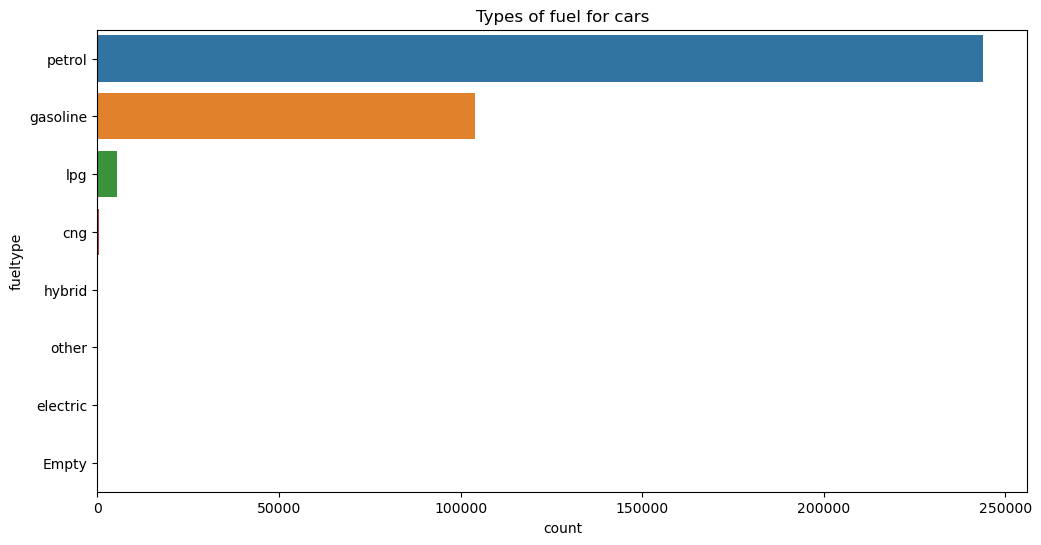

In [77]:
make_plotbar('fueltype', 'Types of fuel for cars')

Gasoline is the most popular fuel

**Quantitative signs**

In [78]:
cars_for_free = df.query('price == 0')
cars_for_free.shape

(10772, 16)

10772 cars are given away for free. Against the background of the rest of the dataset, this is a few lines. I suggest we just remove them

In [79]:
df = df.query('price != 0')

In [80]:
perc = np.arange(0,1,0.05)

In [81]:
df['power'].describe(percentiles = perc)

count    343597.000000
mean        111.000192
std         188.177974
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          54.000000
20%          60.000000
25%          69.000000
30%          75.000000
35%          82.000000
40%          90.000000
45%         101.000000
50%         105.000000
55%         110.000000
60%         116.000000
65%         125.000000
70%         136.000000
75%         143.000000
80%         150.000000
85%         170.000000
90%         180.000000
95%         218.000000
max       20000.000000
Name: power, dtype: float64

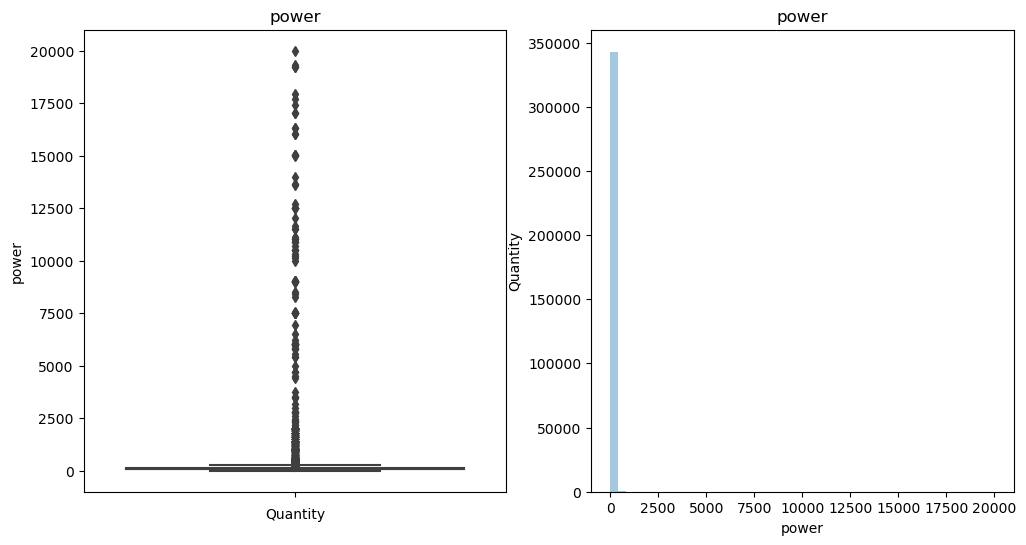

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('power')
sns.boxplot(y = 'power', data=df, ax = axes[0])
axes[0].set_xlabel('Quantity')
     
axes[1].set_title('power')
sns.distplot(df['power'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Quantity')
            
plt.show()

there are a lot of outliers, this makes the graph uninformative

Text(0, 0.5, 'Quantity')

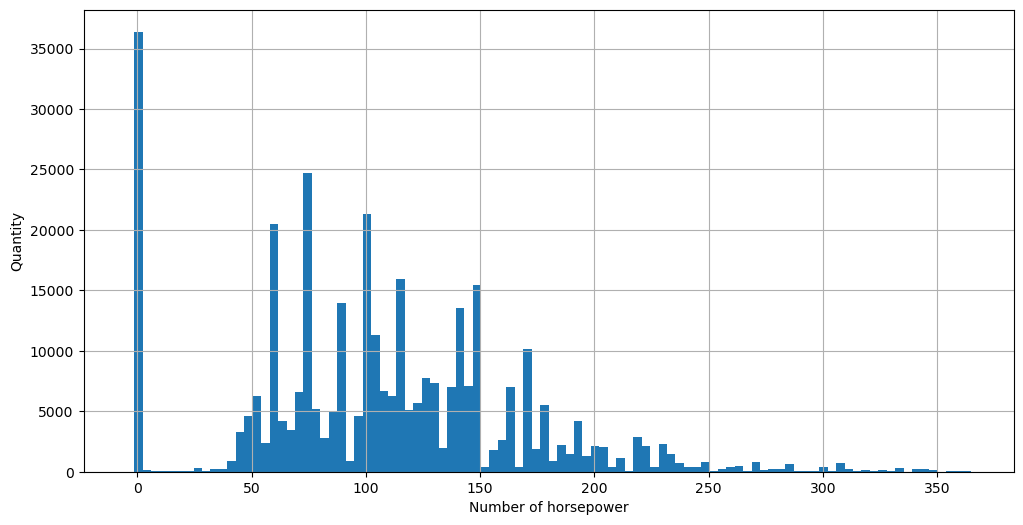

In [83]:
Q1 = df['power'].quantile(0.25)
Q3 = df['power'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['power'].plot(kind = 'hist', bins = 100, grid = True, range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Number of horsepower')
ax.set_ylabel('Quantity')

We took quantiles from the column indicators for the graph, and judging by it, there are mainly cars with a capacity of up to 350 hp. Let's take 350 hp as the maximum of the range, and replace the zeros with medians relative to groups of object models

In [84]:
df = df.query('power <= 350')

In [85]:
medians  = df.groupby('model')['power'].median().to_dict()
def fill_with_median (row):
    if row['power'] == 0:
        return medians [row['model']]
    return row ['power']
df['power'] = df.apply(lambda row: fill_with_median(row), axis = 1)

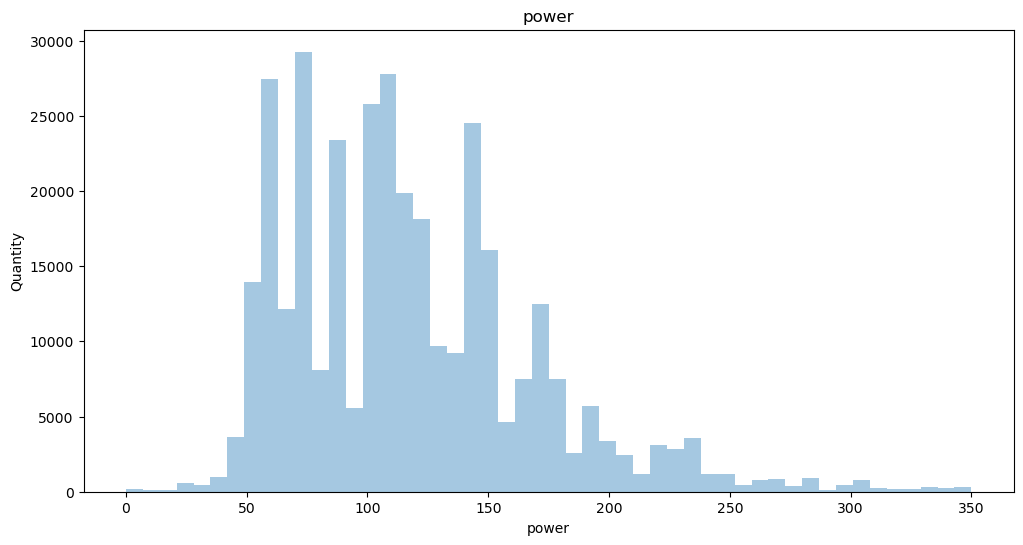

In [86]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('power')
sns.distplot(df['power'], kde=False, bins=50, ax = ax)
ax.set_ylabel('Quantity')          
plt.show()

Removed outliers and zeros from the Power column

In [87]:
df['registrationyear'].describe(percentiles=perc)

count    342441.000000
mean       2004.074962
std          77.973936
min        1000.000000
0%         1000.000000
5%         1993.000000
10%        1996.000000
15%        1997.000000
20%        1998.000000
25%        1999.000000
30%        2000.000000
35%        2000.000000
40%        2001.000000
45%        2002.000000
50%        2003.000000
55%        2004.000000
60%        2005.000000
65%        2006.000000
70%        2007.000000
75%        2008.000000
80%        2009.000000
85%        2010.000000
90%        2012.000000
95%        2016.000000
max        9999.000000
Name: registrationyear, dtype: float64

Let's take the area from 5% in the year of registration column

In [88]:
df = df.query('registrationyear >= 1992 and registrationyear < 2020')

In [89]:
df = df.drop_duplicates().reset_index(drop=True)

Let's drop duplicates

In [90]:
def make_price_plot(feature, title):
    mean_price = df[[feature, 'price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(12,6))
    plt.grid(axis = 'both')
    sns.lineplot(x=feature, y='price', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена в евро', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

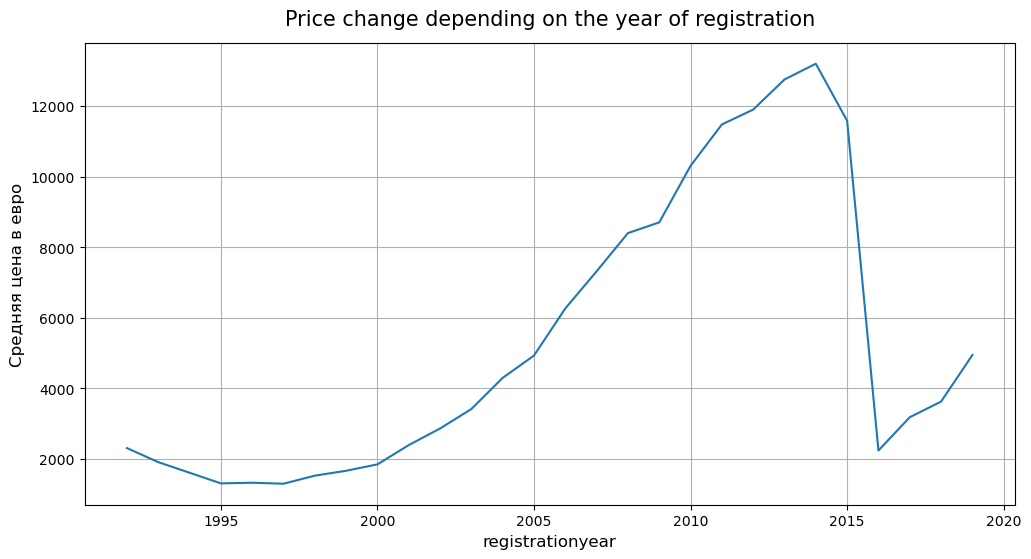

In [91]:
make_price_plot('registrationyear', 'Price change depending on the year of registration')

Изменение цены в зависимости от года регистрации

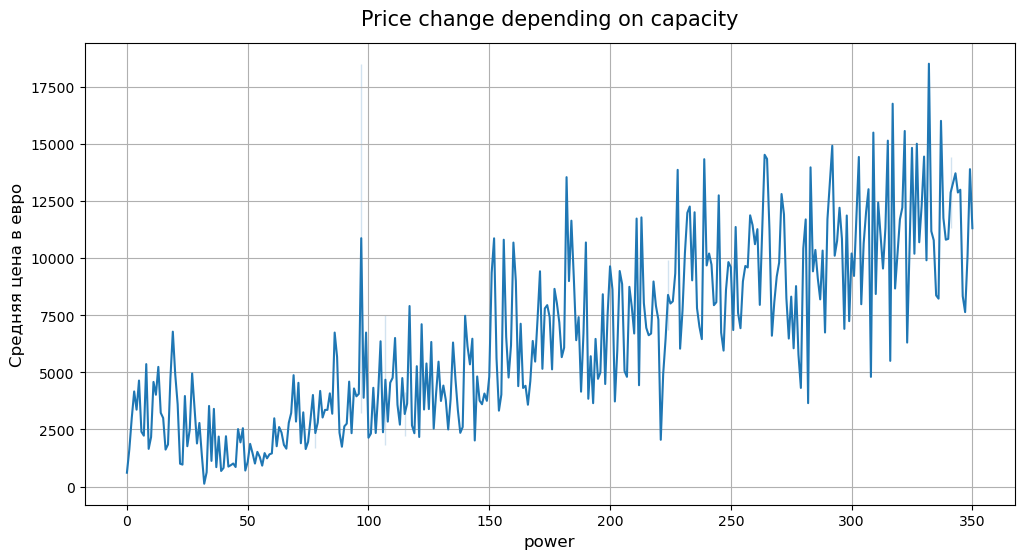

In [92]:
make_price_plot('power', 'Price change depending on capacity')

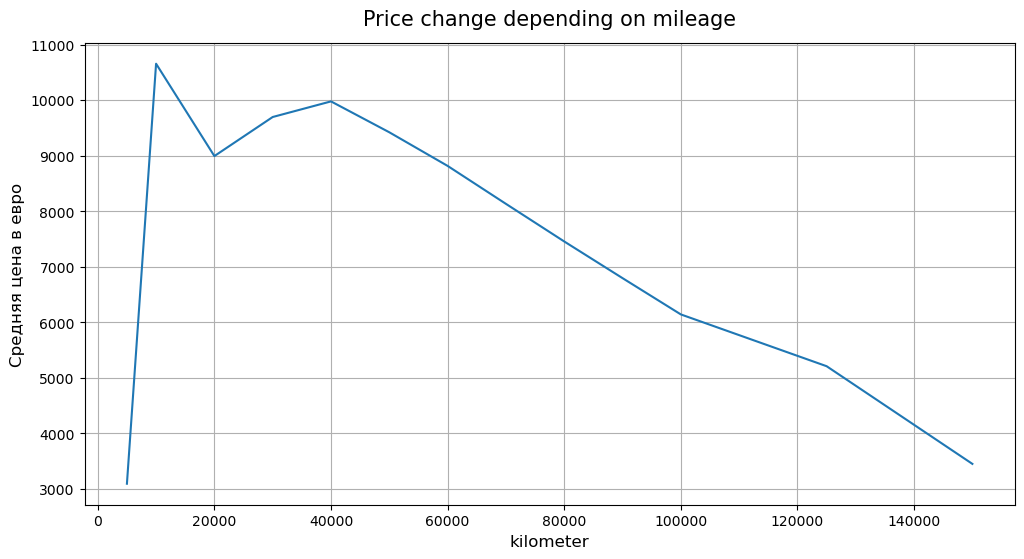

In [93]:
make_price_plot('kilometer', 'Price change depending on mileage')

In [94]:
df.shape

(328421, 16)

<AxesSubplot:>

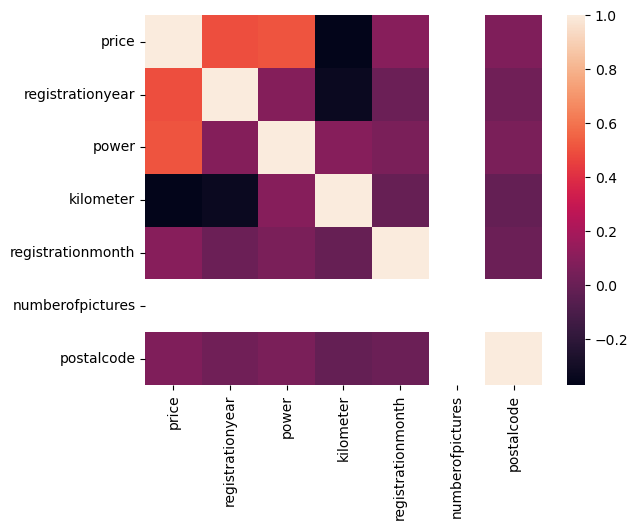

In [95]:
corr = df.corr()
sns.heatmap(corr)

In [96]:
df['price'].corr(df['kilometer'])

-0.36854540478442677

<b>Output of the data processing stage:</b>

After analysis and processing, we lost 1\10 data. It probably won't have much impact on further work.

* The largest number of missing values (20%) was in the NotRepaired column. Most likely, the owners missed this because the car had not been repaired before. Or they simply hid the information so that the car would not seem less attractive to buy. In the other columns, the percentage of missing values was lower, all the omissions were filled in.
* The most popular car brand was Volkswagen;
* The most popular model is Golf;
* The most popular body type is sedan;
* The most popular type of transmission is manual;
* The most popular type of fuel is gasoline;
* The price was not specified for 10.7 thousand cars, these lines were excluded from the dataset;
* Outliers and duplicates have been removed from the *power* and *registrationyear* columns;
* In a time slice in 2015, according to available data, it is possible to observe a trend of global decline in sales volumes of the price level.
* The dependence of the price level on the mileage of the car is available and is logically justified.
* The correlation matrix confirms that there is a relationship between the price and the age of the car (the younger the car, the higher the price), between price and power (the more powerful the car, the higher the price), as well as a negative relationship between price and mileage (the more mileage, the lower the price).

## Model training

Features: 
 - Object: 
       'vehicletype', 'registrationyear', 'gearbox',
       'model', 'fueltype', 'brand',
       'notrepaired'
 - Int: 'power', 'kilometer'

Target: 'price'

We remove unnecessary columns related to the ad, but not to the car, and, accordingly, do not affect its cost.

In [97]:
df = df.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

In [98]:
cats_cols = list(df.select_dtypes(include='object').columns)
label_encode = LabelEncoder()
for column in cats_cols:
    label_encode.fit(df[column].astype('str'))
    df[column] = label_encode.transform(df[column].astype('str'))

Carried out coding of categorical data using Label Encoder

In [99]:
cats_cols

['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [100]:
features = df.drop('price', axis=1)
target = df['price']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RND)
#X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(
#    X_test, y_test, test_size=0.5, random_state=RND)

In [102]:
X_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
181112,4,2016,1,107.0,149,150000,4,6,27,1
178231,1,1998,1,71.0,42,150000,0,6,24,0
287463,4,2002,1,129.0,59,100000,3,4,20,0
197646,0,2006,1,150.0,202,150000,6,6,38,0
78455,7,2009,1,245.0,11,150000,8,2,2,0


We divided the data into training, test and validation samples

In [103]:
scaler = StandardScaler()
quanti_columns = ['registrationyear', 'power', 'kilometer']
scaler.fit(X_train[quanti_columns])

X_train[quanti_columns] = scaler.transform(X_train[quanti_columns])
X_test[quanti_columns] = scaler.transform(X_test[quanti_columns])
#X_train_valid[quanti_columns] = scaler.transform(X_train_valid[quanti_columns])

In [104]:
X_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
181112,4,2.007513,1,-0.222290,149,0.572715,4,6,27,1
178231,1,-1.003763,1,-0.935829,42,0.572715,0,6,24,0
287463,4,-0.334591,1,0.213762,59,-0.785008,3,4,20,0
197646,0,0.334582,1,0.629993,202,0.572715,6,6,38,0
78455,7,0.836461,1,2.512943,11,0.572715,8,2,2,0


Standardized them

### LGB Regressor

In [105]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [0],
        'random_state' : [RND],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=-1)
    grid_cv.fit(features, target, categorical_feature=cats_cols)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [108]:
%%time
lgb_params = lgb_regr(X_train, y_train)

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vladislav/opt/anaconda3/lib/python3.9/site-

Best hyperparams:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 127, 'random_state': 12345, 'verbose': 0}
RMSE score on train sample: 1546.30
CPU times: user 6.12 s, sys: 296 ms, total: 6.41 s
Wall time: 30.9 s


In [109]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10, eval_metric='rmse')
predict_lgb = model_lgb.predict(X_test)
print('Test RMSE = {:.2f}'.format(mse(y_test, predict_lgb)**0.5))

[10]	valid_0's rmse: 2442.53	valid_0's l2: 5.96593e+06
[20]	valid_0's rmse: 1904.24	valid_0's l2: 3.62612e+06
[30]	valid_0's rmse: 1743.77	valid_0's l2: 3.04074e+06
[40]	valid_0's rmse: 1676.07	valid_0's l2: 2.8092e+06
[50]	valid_0's rmse: 1646.9	valid_0's l2: 2.71227e+06
[60]	valid_0's rmse: 1626.09	valid_0's l2: 2.64417e+06
[70]	valid_0's rmse: 1613.04	valid_0's l2: 2.6019e+06
[80]	valid_0's rmse: 1600.84	valid_0's l2: 2.5627e+06
[90]	valid_0's rmse: 1590.05	valid_0's l2: 2.52825e+06
[100]	valid_0's rmse: 1583.38	valid_0's l2: 2.50708e+06
Test RMSE = 1583.38
CPU times: user 7.27 s, sys: 140 ms, total: 7.41 s
Wall time: 2.08 s


Using the LGBMRegressor model, we obtained the following indicators:
- on the training sample: 1546.30
- on the test sample: 1583.38

### CatBoostRegressor

In [116]:
def catboost_regr(features, target):
    model = CatBoostRegressor(verbose=False)
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, cat_features=cats_cols, verbose=False)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [117]:
%%time
catb_params = catboost_regr(X_train, y_train)

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .it

Best hyperparams:  {'max_depth': 10, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE score on train sample: 1584.63
CPU times: user 20.8 s, sys: 490 ms, total: 21.3 s
Wall time: 54.5 s


In [54]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(X_train, y_train, verbose=10)
catb_pred = catb_model.predict(X_test)
print('Test RMSE : {:.2f} '.format(mse(y_test, catb_pred)**0.5))

Learning rate set to 0.5
0:	learn: 3028.1379189	total: 61.1ms	remaining: 6.05s
10:	learn: 1745.7518801	total: 679ms	remaining: 5.5s
20:	learn: 1655.6440317	total: 1.27s	remaining: 4.76s
30:	learn: 1596.6066005	total: 1.88s	remaining: 4.17s
40:	learn: 1559.7702846	total: 2.48s	remaining: 3.57s
50:	learn: 1529.2792190	total: 3.08s	remaining: 2.96s
60:	learn: 1504.2055764	total: 3.69s	remaining: 2.36s
70:	learn: 1483.3936982	total: 4.29s	remaining: 1.75s
80:	learn: 1463.6904140	total: 4.9s	remaining: 1.15s
90:	learn: 1449.0403067	total: 5.51s	remaining: 545ms
99:	learn: 1436.7733426	total: 6.06s	remaining: 0us
Test RMSE : 1568.53 
CPU times: user 6.22 s, sys: 22.5 ms, total: 6.24 s
Wall time: 7.15 s


Using the CatBoostRegressor model, we obtained the following indicators:
- on the training sample: 1584.63
- on the test sample: 1568.53

### XGBRegressor

In [121]:
def xgb_regr(features, target):
    model = XGBRegressor()
    params = {
        'max_depth': [3, 5, 7], 
         'eta': [0.5], 
         'min_child_weight':[4],
         'sampling_method':['gradient_based'], 
         'verbosity':[1],  
         'seed':[RND]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=2, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0)
    grid_cv.fit(features, target, eval_metric='rmse', verbose = 0, eval_set = [(X_test, y_test)])
    print('Best hyperparams: ', grid_cv.best_params_)
    print('Best RMSE score: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [122]:
%%time
xgb_params = xgb_regr(X_train, y_train)

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_pa

Best hyperparams:  {'eta': 0.5, 'max_depth': 7, 'min_child_weight': 4, 'sampling_method': 'gradient_based', 'seed': 12345, 'verbosity': 1}
Best RMSE score: 1607.15
CPU times: user 59.8 s, sys: 432 ms, total: 1min
Wall time: 47.3 s


In [57]:
%%time
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(X_train, y_train, eval_metric='rmse', verbose = 10, eval_set = [(X_test, y_test)])
xgb_pred = model_xgb.predict(X_test)
print('Test RMSE : {:.2f}'.format(mse(y_test, xgb_pred)**0.5))

[0]	validation_0-rmse:3728.91235
[10]	validation_0-rmse:1737.22449
[20]	validation_0-rmse:1674.00427
[30]	validation_0-rmse:1635.47009
[40]	validation_0-rmse:1612.59009
[50]	validation_0-rmse:1603.83142
[60]	validation_0-rmse:1596.39966
[70]	validation_0-rmse:1590.73157
[80]	validation_0-rmse:1583.48535
[90]	validation_0-rmse:1577.42725
[99]	validation_0-rmse:1574.44458
Test RMSE : 1574.45
CPU times: user 2min 49s, sys: 1.04 s, total: 2min 50s
Wall time: 2min 51s


Using the XGBRegressor model, we obtained the following indicators:
- on the training sample: 1607.15
- on the test sample: 1574.45

## Model analysis

We have analyzed and processed the data. We prepared them and trained models based on them. We found the best hyperparameters for models and tested them using the RMSE metric.

In [58]:
results = {
    'Model' : ['LGBMRegressor', 'CatBoostRegressor', 'XGBRegressor'],
    'Train RMSE' :pd.Series([1546.30, 1584.63, 1607.15]),
    'Train Time, sec': pd.Series([30.3, 53.2, 67]),
    'Test RMSE' :pd.Series([1583.38, 1568.53, 1574.45]),
    'Test Time, sec': pd.Series([3.39, 3.91, 16.2])
    }
display(pd.DataFrame(results))

,Model,Train RMSE,"Train Time, sec",Test RMSE,"Test Time, sec"
0,LGBMRegressor,1546.30,30.3,1583.38,3.39
1,CatBoostRegressor,1584.63,53.2,1568.53,3.91
2,XGBRegressor,1607.15,67.0,1574.45,16.20


## <b>Conclusion</b>

According to the results of the study, it can be seen that the CatBoostRegressor model gives the highest accuracy, while its prediction speed is almost the same as that of the fastest model (LGBMRegressor), which makes it optimal in this case. It is the CatBoostRegressor model that needs to be sent to production.